#### Notes on current version:
**To Try**:
- [Cayley parameterization](https://planetmath.org/cayleysparameterizationoforthogonalmatrices) of $SU_d$ (since this is really all we need)...*will it be more stable than Lie's parameterization?* Note: it is a homeomorphism so this is great for UAP!
- SVD approach to pre-trainining 
  - (here for procrustes problem)[https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem]
  - [here for complexity](https://mathoverflow.net/questions/161252/what-is-the-time-complexity-of-truncated-svd)

# NEU (Reconfigurations Map and Related Functions)

### Basic Algorithm (NEU-OLS)

1. Perform Basic Algorithm (in this case OLS)
2. Map predictions to their graph; ie $x\mapsto (x,\hat{f}_{OLS}(x))$ where $\hat{f}_{OLS}$ is the least-squares regression function.

## Initializations:

In [1]:
# Deep Learning & ML
import tensorflow as tf
import tensorflow_probability as tfp
import keras as K
import keras.backend as Kb
from keras.layers import *

from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras import utils as np_utils
from scipy import linalg as scila

from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.constraints import NonNeg



# Linear Regression
from sklearn.linear_model import LinearRegression

# General
import numpy as np
import time

# Alerts
import os as beepsnd

# Others
import math

# General Outputs
print('TensorFlow:', tf.__version__)

Using TensorFlow backend.


TensorFlow: 2.1.0


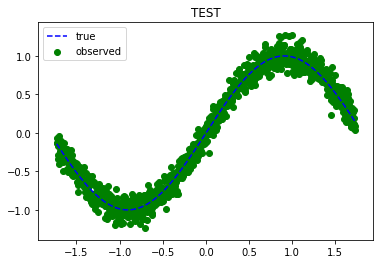

In [15]:
N_Reconfigurations = 200
d = 1 # Dimension of X
D = 1 # Dimension of Y


# Data Meta-Parameters
noise_level = 0.1
uncertainty_level= 0.5

# Training meta-parameters
Pre_Epochs = 10
Full_Epochs = 100

# # Height Per Reconfiguration
# Height_factor_Per_reconfig = d+D

# Number of Datapoints
N_data = 10**3
# Unknown Function
def unknown_f(x):
    return np.sin(x) #+ (x % 2)

# Generate Data
%run Data_Generator.ipynb

#### Prepare data for NEU

In [3]:
# Reshape Data Into Compatible Shape
data_x = np.array(data_x).reshape(-1,d)
data_y = np.array(data_y)
# Perform OLS Regression
linear_model = LinearRegression()
reg = linear_model.fit(data_x, data_y)
model_pred_y = linear_model.predict(data_x)
# Map to Graph
data_NEU = np.concatenate((data_x,model_pred_y.reshape(-1,D)),1)
NEU_targets  = data_y.reshape(-1,D)

### Helper Function(s)

In [4]:
def above_percentile(x, p): #assuming the input is flattened: (n,)

    samples = Kb.cast(Kb.shape(x)[0], Kb.floatx()) #batch size
    p =  (100. - p)/100.  #100% will return 0 elements, 0% will return all elements

    #samples to get:
        #you can choose tf.math.ceil above, it depends on whether you want to
        #include or exclude one element. Suppose you you want 33% top,
        #but it's only possible to get exactly 30% or 40% top:
        #floor will get 30% top and ceil will get 40% top.
        #(exact matches included in both cases)

    #selected samples
    values, indices = tf.math.top_k(x, samples)

    return values

# def Robust_MSE(p):
#     def loss(y_true, y_predicted):
#         ses = Kb.pow(y_true-y_predicted,2)
#         above = above_percentile(Kb.flatten(ses), p)
#         return Kb.mean(above)
#     return loss
def Robust_MSE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    y_true.shape = (y_true.shape[0], 1)
    y_pred.shape = (y_pred.shape[0], 1)

    # Compute Exponential Utility
    loss_out = np.abs((y_true - y_pred))
    loss_out = np.math.exp(-p*loss_out)
    loss_out = np.mean(loss_out)
    return loss_out

### Build Reconfiguration Unit
*Lie Version:* $$
x \mapsto \exp\left(
%\psi(a\|x\|+b)
\operatorname{Skew}_d\left(
    F(\|x\|)
\right)
\right) x.
$$

*Cayley version:*
$$
\begin{aligned}
x \mapsto & \left[(I_d + A(x))(I- A(x))^{-1}\right]x
\\
A(x)\triangleq &%\psi(a\|x\|+b)
\operatorname{Skew}_d\left(
    F(\|x\|)\right)
\end{aligned}
$$

tf.linalg.inv

In [5]:
class Reconfiguration_unit(tf.keras.layers.Layer):
    
    def __init__(self, units=16, input_dim=32):
        super(Reconfiguration_unit, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        #------------------------------------------------------------------------------------#
        # Center
        #------------------------------------------------------------------------------------#
        self.location = self.add_weight(name='location',
                                    shape=(self.units,),
                                    initializer='random_normal',
                                    trainable=True)
        
        #------------------------------------------------------------------------------------#
        # Bump Function
        #------------------------------------------------------------------------------------#
#         self.sigma = self.add_weight(name='bump_threshfold',
#                                         shape=[1],
#                                         initializer=RandomUniform(minval=.5, maxval=1),
#                                         trainable=True,
#                                         constraint=tf.keras.constraints.NonNeg())
#         self.a = self.add_weight(name='bump_scale',
#                                         shape=[1],
#                                         initializer='ones',
#                                         trainable=True)
#         self.b = self.add_weight(name='bump_location',
#                                         shape=[1],
#                                         initializer='zeros',
#                                         trainable=True)

        #------------------------------------------------------------------------------------#
        # Tangential Map
        #------------------------------------------------------------------------------------#
        self.Id = self.add_weight(name='Identity_Matrix',
                                   shape=(input_shape[-1],input_shape[-1]),
                                   initializer='identity',
                                   trainable=False)
        self.Tw1 = self.add_weight(name='Tangential_Weights_1 ',
                                   shape=(input_shape[-1],input_shape[-1]),
                                   initializer='GlorotUniform',
                                   trainable=True)
        
        self.Tw2 = self.add_weight(name='Tangential_Weights_2 ',shape=(input_shape[-1],input_shape[-1]),initializer='GlorotUniform',trainable=True)

        self.Tb1 = self.add_weight(name='Tangential_basies_1',shape=(input_shape[-1],input_shape[-1]),initializer='GlorotUniform',trainable=True)
        self.num_stab_param = self.add_weight(name='matrix_exponential_stabilizer',shape=[1],initializer=RandomUniform(minval=0.0, maxval=0.01),trainable=True,constraint=tf.keras.constraints.NonNeg())
        
        # Wrap things up!
        super().build(input_shape)

    def bump_function(self, x):
        return tf.math.exp(-self.sigma / (self.sigma - x))

        
    def call(self, input):
        #------------------------------------------------------------------------------------#
        # Initializations
        #------------------------------------------------------------------------------------#
        norm_inputs = tf.math.reduce_sum((input*input)) #WLOG if norm is squared!
        
        #------------------------------------------------------------------------------------#
        # Bump Function
        #------------------------------------------------------------------------------------#
#         bump_input = self.a *norm_inputs + self.b
#         greater = tf.math.greater(bump_input, -self.sigma)
#         less = tf.math.less(bump_input, self.sigma)
#         condition = tf.logical_and(greater, less)

#         output_bump = tf.where(
#             condition, 
#             self.bump_function(bump_input),
#             0.0)
        
        
        
        
        #------------------------------------------------------------------------------------#
        # Tangential Map
        #------------------------------------------------------------------------------------#
        # Build Radial, Tangent-Space Valued Function, i.e.: C(R^d,so_d) st. f(x)=f(y) if |x|=|y|
        
        
        # Build Tangential Feed-Forward Network (Bonus)
        #-----------------------------------------------#
        tangential_ffNN = norm_inputs*self.Tw1
        tangential_ffNN = tangential_ffNN + self.Tb1
        tangential_ffNN = tf.nn.relu(tangential_ffNN)  
        tangential_ffNN = tf.matmul(tangential_ffNN, self.Tw2) 
    
        # Scale DNN by Radial-Data
#         tangential_ffNN = output_bump*tangential_ffNN
        # Map to Rotation-Matrix-Valued Function #
        #----------------------------------------#
        tangential_ffNN = (tf.transpose(tangential_ffNN) - tangential_ffNN) 
#         tangential_ffNN = output_bump*tangential_ffNN
        tangential_ffNN = tangential_ffNN + self.num_stab_param*tf.linalg.diag(tf.ones(d+D))
    
        # Lie Parameterization (Problematic)
        #tangential_ffNN = tf.linalg.expm(tangential_ffNN)
        # Cayley Transformation (Experimental)
        tangential_ffNN = tf.linalg.matmul((self.Id + tangential_ffNN),tf.linalg.inv(self.Id - tangential_ffNN))
        
        # Exponentiation and Action
        #----------------------------#
        x_out = tf.linalg.matvec(tangential_ffNN,(input-self.location)) + self.location
        
        # Return Output
        return x_out

### Projection Layer

In [6]:
projection_layer = tf.keras.layers.Lambda(lambda x: x[:, -D:])

# Build

In [7]:
# define and fit the base model
def get_base_model(trainx, trainy, Pre_Epochs_in):
    # Define Model
    #----------------#
    # Initialize
    input_layer = tf.keras.Input(shape=[d+D])
    # Apply Reconfiguration Unit
    reconfiguration_unit  = Reconfiguration_unit(d+D)(input_layer)
    # Output
    output_layer = projection_layer(reconfiguration_unit)
    reconfiguration_basic = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
    
    # Compile Model
    #----------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile
    reconfiguration_basic.compile(loss = 'mae',
                    optimizer = optimizer_on,
                    metrics = ['mse'])
    
    # Fit Model
    #----------------#
    reconfiguration_basic.fit(trainx, trainy, epochs=Pre_Epochs_in, verbose=0)
        
    # Return Output
    return reconfiguration_basic

#### Greedy Initialization of Subsequent Units
Build reconfiguration and pre-train using greedy approach.

In [8]:
def add_reconfiguration_unit_greedily(model, trainx, trainy, Pre_Epochs_in):

    # Dissasemble Network
    layers = [l for l in model.layers]

    # Define new reconfiguration unit to be added
    new_reconfiguration_unit  = Reconfiguration_unit(d+D)(layers[len(layers)-2].output)

    # Output Layer
    output_layer_new = projection_layer(new_reconfiguration_unit)

    for i in range(len(layers)):
        layers[i].trainable = False


    # build model
    new_model = tf.keras.Model(inputs=[layers[0].input], outputs=output_layer_new)
    #new_model.summary()


    # Compile new Model
    #-------------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-2), momentum=0.01, nesterov=True)
    # Compile Model
    new_model.compile(loss = 'mae',
                    optimizer = optimizer_on,
                    metrics = ['mse'])

    # Fit Model
    #----------------#
    new_model.fit(trainx, trainy, epochs=Pre_Epochs_in, verbose=0)

    # Return Output
    return new_model

#### Train and Compile (entire) reconfiguration using greedy-initializations past from previous helper functions.
Train reconfiguration together (initialized by greedy) layer-wise initializations.

In [9]:
def build_reconfiguration(model_greedy_initialized, trainx, trainy, Full_Epochs_in):

    # Dissasemble Network
    layers = [l for l in model_greedy_initialized.layers]

    # Define new reconfiguration unit to be added
    new_reconfiguration_unit  = Reconfiguration_unit(d+D)(layers[len(layers)-2].output)

    # Output Layer
    output_layer_new = projection_layer(new_reconfiguration_unit)

    for i in range(len(layers)):
        layers[i].trainable = True


    # build model
    reconfiguration = tf.keras.Model(inputs=[layers[0].input], outputs=output_layer_new)
    #new_model.summary()



    # Compile new Model
    #-------------------#
    # Define Optimizer
    optimizer_on = tf.keras.optimizers.SGD(learning_rate=10**(-5), momentum=0.01, nesterov=True)
    #optimizer_on = tf.keras.optimizers.Adagrad(learning_rate=10**(-5), initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')

    # Compile Model
    reconfiguration.compile(loss = 'mae',
                    optimizer = optimizer_on,
                    metrics = ['mse'])

    # Fit Model
    #----------------#
    reconfiguration.fit(trainx, trainy, epochs=Full_Epochs_in, verbose=1)

    # Return Output
    return reconfiguration

# Train the model

In [10]:
# Base Model
model = get_base_model(data_NEU,NEU_targets,10)

# Greedy Initialization
NEU_OLS_Greedy_init = model
for i in range(N_Reconfigurations):
    # Update Model
    NEU_OLS_Greedy_init_temp = add_reconfiguration_unit_greedily(NEU_OLS_Greedy_init,
                                                                 data_NEU,
                                                                 NEU_targets,
                                                                 Pre_Epochs)
    
    # Check for Blowup
    if math.isnan(np.mean(NEU_OLS_Greedy_init.predict(data_NEU))):
        NEU_OLS_Greedy_init = NEU_OLS_Greedy_init
        break
    else: #Update Model if not explosion
        NEU_OLS_Greedy_init = NEU_OLS_Greedy_init_temp
    
    print(np.mean((NEU_OLS_Greedy_init.predict(data_NEU) - data_y)**2))
    
    # Update User on Status of Initialization
    print(((i+1)/N_Reconfigurations))

0.14249677155805995
0.005
1.8868288316444468
0.01
0.15521904750731227
0.015
0.15535795629066435
0.02
0.13181194526577245
0.025
0.13238689013604213
0.03
1.4697877369026926
0.035
0.1567292078784923
0.04
1.3912593030957079
0.045
0.10006457664894106
0.05
1.5601539456466014
0.055
0.09384572869590664
0.06
1.6363498128613998
0.065
0.09732008156543534
0.07
1.6580994056631202
0.075
0.10302590635563975
0.08
0.11028647880751972
0.085
1.7053652847038276
0.09
0.11881907618367006
0.095
1.7289716378665634
0.1
0.16627547648629584
0.105
1.4447979915150577
0.11
0.13258727008601084
0.115
1.513406758589115
0.12
0.15907785924890275
0.125
0.3827125362624159
0.13
1.985244190488314
0.135
1.985303074118812
0.14
0.4068619562795264
0.145
1.9674522663644678
0.15
0.3673257113860202
0.155
2.100787369658784
0.16
0.35762443188222803
0.165
2.170135047700476
0.17
0.3579212237376866
0.175
2.216267154639846
0.18
0.387088867301748
0.185
0.3868274593159905
0.19
1.9972987019267163
0.195
0.38746566582843495
0.2
2.10352526734

## Train NEU-OLS

In [28]:
NEU_OLS = NEU_OLS_Greedy_init
NEU_OLS.fit(data_NEU,NEU_targets,epochs = Full_Epochs)

Train on 1000 samples
Epoch 1/800
1000/1000 [==============================] - 1s 618us/sample - loss: 1.2628 - mse: 1.8421
Epoch 2/800
1000/1000 [==============================] - 1s 626us/sample - loss: 1.2614 - mse: 1.8394
Epoch 3/800
1000/1000 [==============================] - 1s 601us/sample - loss: 1.2610 - mse: 1.8388
Epoch 4/800
1000/1000 [==============================] - 1s 631us/sample - loss: 1.2605 - mse: 1.8363
Epoch 5/800
1000/1000 [==============================] - 1s 586us/sample - loss: 1.2648 - mse: 1.8486
Epoch 6/800
1000/1000 [==============================] - 1s 613us/sample - loss: 1.2633 - mse: 1.8447
Epoch 7/800
1000/1000 [==============================] - 1s 601us/sample - loss: 1.2614 - mse: 1.8385
Epoch 8/800
1000/1000 [==============================] - 1s 626us/sample - loss: 1.2606 - mse: 1.8366
Epoch 9/800
1000/1000 [==============================] - 1s 615us/sample - loss: 1.2646 - mse: 1.8502
Epoch 10/800
1000/1000 [==============================] - 1s

1000/1000 [==============================] - 1s 1ms/sample - loss: 1.2584 - mse: 1.8319
Epoch 81/800
1000/1000 [==============================] - 1s 888us/sample - loss: 1.2555 - mse: 1.8248
Epoch 82/800
1000/1000 [==============================] - 1s 645us/sample - loss: 1.2644 - mse: 1.8465
Epoch 83/800
1000/1000 [==============================] - 1s 611us/sample - loss: 1.2637 - mse: 1.8446
Epoch 84/800
1000/1000 [==============================] - 1s 568us/sample - loss: 1.2681 - mse: 1.8601
Epoch 85/800
1000/1000 [==============================] - 1s 633us/sample - loss: 1.2586 - mse: 1.8324
Epoch 86/800
1000/1000 [==============================] - 1s 995us/sample - loss: 1.2646 - mse: 1.8504
Epoch 87/800
1000/1000 [==============================] - 1s 669us/sample - loss: 1.2646 - mse: 1.8473
Epoch 88/800
1000/1000 [==============================] - 1s 644us/sample - loss: 1.2611 - mse: 1.8381
Epoch 89/800
1000/1000 [==============================] - 1s 632us/sample - loss: 1.2627

1000/1000 [==============================] - 1s 1ms/sample - loss: 1.2637 - mse: 1.8449
Epoch 160/800
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.2635 - mse: 1.8453
Epoch 161/800
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.2632 - mse: 1.8431
Epoch 162/800
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.2654 - mse: 1.8507
Epoch 163/800
1000/1000 [==============================] - 1s 708us/sample - loss: 1.2619 - mse: 1.8426
Epoch 164/800
1000/1000 [==============================] - 1s 658us/sample - loss: 1.2642 - mse: 1.8472
Epoch 165/800
1000/1000 [==============================] - 1s 635us/sample - loss: 1.2659 - mse: 1.8535
Epoch 166/800
1000/1000 [==============================] - 1s 690us/sample - loss: 1.2645 - mse: 1.8493
Epoch 167/800
1000/1000 [==============================] - 1s 650us/sample - loss: 1.2637 - mse: 1.8448
Epoch 168/800
1000/1000 [==============================] - 1s 571us/sample - loss: 1.2

1000/1000 [==============================] - 1s 646us/sample - loss: 1.2638 - mse: 1.8473
Epoch 238/800
1000/1000 [==============================] - 1s 653us/sample - loss: 1.2631 - mse: 1.8441
Epoch 239/800
1000/1000 [==============================] - 1s 580us/sample - loss: 1.2626 - mse: 1.8432
Epoch 240/800
1000/1000 [==============================] - 1s 735us/sample - loss: 1.2634 - mse: 1.8455
Epoch 241/800
1000/1000 [==============================] - 1s 575us/sample - loss: 1.2626 - mse: 1.8415
Epoch 242/800
1000/1000 [==============================] - 1s 686us/sample - loss: 1.2585 - mse: 1.8339
Epoch 243/800
1000/1000 [==============================] - 1s 636us/sample - loss: 1.2656 - mse: 1.8525
Epoch 244/800
1000/1000 [==============================] - 1s 690us/sample - loss: 1.2630 - mse: 1.8449
Epoch 245/800
1000/1000 [==============================] - 1s 626us/sample - loss: 1.2619 - mse: 1.8416
Epoch 246/800
1000/1000 [==============================] - 1s 599us/sample - l

1000/1000 [==============================] - 1s 826us/sample - loss: 1.2673 - mse: 1.8593
Epoch 316/800
1000/1000 [==============================] - 1s 626us/sample - loss: 1.2603 - mse: 1.8364
Epoch 317/800
1000/1000 [==============================] - 1s 635us/sample - loss: 1.2682 - mse: 1.8598
Epoch 318/800
1000/1000 [==============================] - 1s 713us/sample - loss: 1.2609 - mse: 1.8368
Epoch 319/800
1000/1000 [==============================] - 1s 728us/sample - loss: 1.2655 - mse: 1.8503
Epoch 320/800
1000/1000 [==============================] - 1s 853us/sample - loss: 1.2617 - mse: 1.8396
Epoch 321/800
1000/1000 [==============================] - 1s 619us/sample - loss: 1.2658 - mse: 1.8509
Epoch 322/800
1000/1000 [==============================] - 1s 650us/sample - loss: 1.2622 - mse: 1.8420
Epoch 323/800
1000/1000 [==============================] - 1s 650us/sample - loss: 1.2623 - mse: 1.8438
Epoch 324/800
1000/1000 [==============================] - 1s 700us/sample - l

1000/1000 [==============================] - 1s 1ms/sample - loss: 1.2615 - mse: 1.8384
Epoch 394/800
1000/1000 [==============================] - 1s 611us/sample - loss: 1.2577 - mse: 1.8274
Epoch 395/800
1000/1000 [==============================] - 1s 821us/sample - loss: 1.2644 - mse: 1.8492
Epoch 396/800
1000/1000 [==============================] - 1s 939us/sample - loss: 1.2616 - mse: 1.8394
Epoch 397/800
1000/1000 [==============================] - 1s 930us/sample - loss: 1.2630 - mse: 1.8424
Epoch 398/800
1000/1000 [==============================] - 1s 780us/sample - loss: 1.2589 - mse: 1.8314
Epoch 399/800
1000/1000 [==============================] - 1s 644us/sample - loss: 1.2670 - mse: 1.8566
Epoch 400/800
1000/1000 [==============================] - 1s 517us/sample - loss: 1.2635 - mse: 1.8448
Epoch 401/800
1000/1000 [==============================] - 1s 510us/sample - loss: 1.2656 - mse: 1.8520
Epoch 402/800
1000/1000 [==============================] - 1s 533us/sample - los

Epoch 472/800
1000/1000 [==============================] - 1s 601us/sample - loss: 1.2644 - mse: 1.8480
Epoch 473/800
1000/1000 [==============================] - 1s 768us/sample - loss: 1.2662 - mse: 1.8510
Epoch 474/800
1000/1000 [==============================] - 1s 1ms/sample - loss: 1.2619 - mse: 1.8401
Epoch 475/800
1000/1000 [==============================] - 1s 847us/sample - loss: 1.2596 - mse: 1.8362
Epoch 476/800
1000/1000 [==============================] - 1s 734us/sample - loss: 1.2561 - mse: 1.8318
Epoch 477/800
1000/1000 [==============================] - 1s 530us/sample - loss: 1.2622 - mse: 1.8416
Epoch 478/800
1000/1000 [==============================] - 1s 530us/sample - loss: 1.2639 - mse: 1.8470
Epoch 479/800
1000/1000 [==============================] - 1s 547us/sample - loss: 1.2629 - mse: 1.8436
Epoch 480/800
1000/1000 [==============================] - 1s 579us/sample - loss: 1.2623 - mse: 1.8429
Epoch 481/800
1000/1000 [==============================] - 1s 602u

1000/1000 [==============================] - 1s 525us/sample - loss: 1.2585 - mse: 1.8322
Epoch 551/800
1000/1000 [==============================] - 1s 543us/sample - loss: 1.2627 - mse: 1.8411
Epoch 552/800
1000/1000 [==============================] - 1s 510us/sample - loss: 1.2665 - mse: 1.8552
Epoch 553/800
1000/1000 [==============================] - 1s 514us/sample - loss: 1.2613 - mse: 1.8390
Epoch 554/800
1000/1000 [==============================] - 1s 513us/sample - loss: 1.2635 - mse: 1.8446
Epoch 555/800
1000/1000 [==============================] - 1s 509us/sample - loss: 1.2637 - mse: 1.8437
Epoch 556/800
1000/1000 [==============================] - 1s 514us/sample - loss: 1.2619 - mse: 1.8403
Epoch 557/800
1000/1000 [==============================] - 1s 510us/sample - loss: 1.2661 - mse: 1.8554
Epoch 558/800
1000/1000 [==============================] - 1s 510us/sample - loss: 1.2610 - mse: 1.8388
Epoch 559/800
1000/1000 [==============================] - 1s 519us/sample - l

KeyboardInterrupt: 

## Make Predictions

In [29]:
# # Predictions (for comparison: TEMP)
NEU_OLS_prediction = NEU_OLS.predict(data_NEU)
NEU_OLS_single_unit_prediction = model.predict(data_NEU)
NEU_OLS_greedy_initializations = NEU_OLS_Greedy_init.predict(data_NEU)

# Visualize Predictions

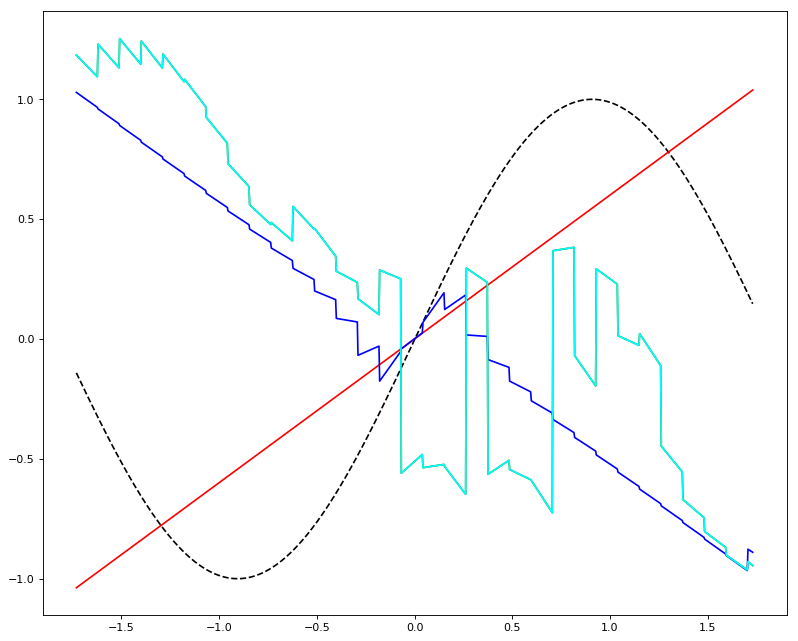

In [30]:
# Adjust Figure Details
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

# Data Plot
plt.plot(data_x,true_y,color='k',label='true',linestyle='--')

# Plot Models
plt.plot(data_x,model_pred_y,color='r',label='OLS')
plt.plot(data_x,NEU_OLS_single_unit_prediction,color='b',label='NEU_Unit')
plt.plot(data_x,NEU_OLS_greedy_initializations,color='g',label='NEU_Greedy_Init')
plt.plot(data_x,NEU_OLS_prediction,color='Aqua',label='NEU-OLS')

 ---

#### The END